In [1]:
import pandas as pd
import gensim
from konlpy.tag import Komoran
import sentencepiece as spm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.rcParams['axes.unicode_minus'] = False
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(context='notebook',
              style='darkgrid',
              palette='pastel',
              font='Malgun Gothic',
              rc=custom_params)

In [3]:
# 자동차 사전 데이터 불러오기
def load_car_dic():
    car_dic_file = open('carDic.txt','r',encoding='utf8')
    car_dic = set(car_dic_file.read().split('\n'))
    return car_dic

car_dic = load_car_dic()
print(len(car_dic))

1433


In [4]:
memo_data = pd.read_csv('car_inspect_info.tsv', sep='\t', lineterminator='\r')
memo_data = memo_data.drop(columns=['inspect_id', 'car_id', 'price']) # drop columns
memo_data = memo_data.dropna() # drop nan row
print(len(memo_data))
memo_data.head()

254142


,inspect_at,inspect_type,description
0,2020-03-09,타이어수리(후우),조수석뒤타이어 현장펑크수리
1,2020-01-07,미션오일,단양애니카_미션오일 교환
2,2020-01-14,점화플러그,당진세계모터스_점화플러그 교환
3,2020-01-14,브레이크액,당진세계모터스-브레이크오일 교환
4,2020-01-06,브레이크액,당진세계모터스_브레이크오일 교환


### sentences 전처리

In [5]:
with open('car_info_description.txt','w',encoding='utf8') as w, open('KCC150_100k.txt','r',encoding='utf8') as corpus:
    w.write('\n'.join(memo_data['description']))
    for idx, snt in enumerate(corpus.readlines()):
        w.write(snt)

In [6]:
spm.SentencePieceTrainer.Train(f'--input=car_info_description.txt --model_prefix=description --vocab_size=6000')
sp = spm.SentencePieceProcessor()
vocab_file = 'description.model'
sp.load(vocab_file)

True

In [7]:
def to_token(df, col):

    morph_description = []
    for _, row in df.iterrows():
        memo = row[col]
        sp_out = sp.encode_as_pieces(memo.replace('_',' ').replace('-',' ').replace('/',' ').replace('ㄴ',' ').replace('#',' ').replace('=',' ').replace(')',' ) ').replace('(',' ( '))
        morph_description.append(' '.join([token.replace('▁','') for token in sp_out]))

    df["subword_description"] = morph_description
    return df

memo_data = to_token(memo_data, "description")
memo_data.head()

,inspect_at,inspect_type,description,subword_description
0,2020-03-09,타이어수리(후우),조수석뒤타이어 현장펑크수리,조수석 뒤 타이어 현장 펑크수리
1,2020-01-07,미션오일,단양애니카_미션오일 교환,단 양 애 니 카 미션오일 교환
2,2020-01-14,점화플러그,당진세계모터스_점화플러그 교환,당진세계모터스 점화플러그 교환
3,2020-01-14,브레이크액,당진세계모터스-브레이크오일 교환,당진세계모터스 브레이크오일 교환
4,2020-01-06,브레이크액,당진세계모터스_브레이크오일 교환,당진세계모터스 브레이크오일 교환


### Word2vec 사용하기

In [8]:
w2v_train = list(memo_data['subword_description'])
w2v_train = [line.split() for line in w2v_train]

model = gensim.models.word2vec.Word2Vec(w2v_train, vector_size=300, window=5, min_count=1, epochs=10)

In [9]:
model.wv.most_similar('타이어', topn=10)

[('전우타이어', 0.6516146063804626),
 ('앞타이어', 0.604376494884491),
 ('전좌타이어', 0.5791398286819458),
 ('후우타이어', 0.5497062802314758),
 ('후좌타이어', 0.5382509827613831),
 ('바퀴', 0.5217775702476501),
 ('타이어펑크', 0.5177106857299805),
 ('륜', 0.4771993160247803),
 ('펑크', 0.46602895855903625),
 ('타이어교체', 0.4468853175640106)]

In [10]:
model.wv.most_similar('경고등', topn=10)

[('엔진체크등', 0.701880931854248),
 ('공기압경고등', 0.6759686470031738),
 ('고장코드', 0.6326425075531006),
 ('기억', 0.5805225372314453),
 ('통합경고등', 0.5681738257408142),
 ('체크', 0.533349871635437),
 ('라이트경고등', 0.5325048565864563),
 ('과거', 0.5064188241958618),
 ('돔', 0.48922085762023926),
 ('룸', 0.4791662395000458)]

In [11]:
# 유사도가 평균값 이상인 것만 선택 하는 함수
def exclusion(word_list):

    count = sum([score for _, score in word_list])
    avg = count / len(word_list)
  
    up_word = []
    for w, s in word_list:
        if s > avg:
            up_word.append(w)
  
    return up_word

In [12]:
light = model.wv.most_similar('라이트', topn=20)
light_word = exclusion(light)
light = model.wv.most_similar('전구', topn=20)
light_word.extend(exclusion(light))

light_word.append('라이트')
light_word.append('전구')

light_word = set(light_word)

error = model.wv.most_similar('경고등', topn=10)
error_word = exclusion(error)
error_word.append('경고등')

print(light_word)
print('')
print(error_word)

{'전구', '라이트', '하향등', '주간주행등', '전조등', '미등', '헤드라이트', '후미등', '브레이크등', '방향지시등', '보조제동등', '백색더블', '데이라이트', '브레이크전구', '라이트전구', '안개등', '주행등'}

['엔진체크등', '공기압경고등', '고장코드', '기억', '경고등']


In [13]:
# 매핑 테이블 작성
mapping_table = {'내비게이션':'네비게이션', '내비':'네비게이션', '네비':'네비게이션', \
                  '딜리버리':'탁송', '탁송비':'탁송', \
                  '브레이크 오일':'브레이크액', '브레이크오일':'브레이크액', \
                  '라디오':'오디오'}

# "라이트" 관련 단어 매핑 테이블 추가
light_mapping = dict()
for word in light_word:
    light_mapping[word] = '라이트'

mapping_table.update(light_mapping)

# "경고등" 관련 단어 매핑 테이블 추가
error_mapping = dict()
for word in error_word:
    error_mapping[word] = '경고등'

mapping_table.update(error_mapping)

print(mapping_table)

{'내비게이션': '네비게이션', '내비': '네비게이션', '네비': '네비게이션', '딜리버리': '탁송', '탁송비': '탁송', '브레이크 오일': '브레이크액', '브레이크오일': '브레이크액', '라디오': '오디오', '전구': '라이트', '라이트': '라이트', '하향등': '라이트', '주간주행등': '라이트', '전조등': '라이트', '미등': '라이트', '헤드라이트': '라이트', '후미등': '라이트', '브레이크등': '라이트', '방향지시등': '라이트', '보조제동등': '라이트', '백색더블': '라이트', '데이라이트': '라이트', '브레이크전구': '라이트', '라이트전구': '라이트', '안개등': '라이트', '주행등': '라이트', '엔진체크등': '경고등', '공기압경고등': '경고등', '고장코드': '경고등', '기억': '경고등', '경고등': '경고등'}


In [14]:
#total 45 category
category = set(memo_data['inspect_type'])
print(len(category))

45


In [15]:
print(category)

{'운영상태점검', 'CSA', '사고조사', '브레이크액', '출장점검', '타이어일반', '블랙박스', '점화플러그', '와이퍼', '타이어수리(후좌)', '키케이블', '휠캡', '장애처리', '타이어교체(후우)', '세차점검', 'CSA_A/S', '하이패스', '타이어교체(전우)', '타이어교체(전좌)', '배터리', '엔진오일', '컴파운드', '재충전배터리', '일반수리', '타이어교체(후좌)', '네비게이션', '미션오일', '후방카메라', '에어컨필터', 'V리브드벨트', '후패드', 'TCS', '상품화점검', '타이어수리(전우)', '사고수리', '주차장위치', '얼라이먼트', '타이어수리(후우)', '타이어수리(전좌)', '기타', '전패드', '브레이크', '정기검사', '아이들러베어링', '전압관리'}


In [16]:
def noun_phrase(words):
    result = []

    for index, token in enumerate(words):
        if (token in car_dic) or (token in category):
            
            if (''.join(words[index : index +2]) in car_dic) or (''.join(words[index : index +2]) in category):
                result.append(''.join(words[index : index +2]))
            
            result.append(token)
    return result

def find_category(row):
   
    line = row['description'].replace('_',' ').replace('-',' ').replace('/',' ').replace('ㄴ',' ').replace('#',' ').replace('=',' ').replace(')',' ) ').replace('(',' ( ')
    car_token = noun_phrase(line.upper().split())
 
    car_token.extend(noun_phrase(row['subword_description'].upper().split()))
    return set(car_token)

In [17]:
subword_list = []
for _, row in memo_data.iterrows():
    if row['inspect_type'] == '장애처리':
        car_words = find_category(row) 
    
        if len(car_words) >= 1: 
            subword_list.extend(car_words)

subword_list = [subword for subword in subword_list if subword != '']
subword_counter = Counter(subword_list) 
subword_sort = sorted(subword_counter.items(), key=lambda x:x[1], reverse=True)
subword_top20 = [(key, value) for key, value in subword_sort[:20]]

print(subword_top20)

[('장애처리', 1238), ('TCS', 613), ('하이패스', 543), ('타이어', 495), ('출장점검', 472), ('배터리', 273), ('후방카메라', 233), ('네비게이션', 216), ('블랙박스', 190), ('사고조사', 180), ('전조등', 129), ('전원', 120), ('컴파운드', 119), ('전구', 113), ('범퍼', 93), ('심', 86), ('도어', 84), ('제동등', 79), ('브레이크', 60), ('불량', 53)]


In [18]:
def re_ranking(word_list):

    max_word = (None, -99)
    for word in word_list:
        if word in mapping_table:
            word = mapping_table.get(word)

        if subword_counter[word] > max_word[1]:
            max_word = (word, subword_counter[word])

    return max_word[0]

In [19]:
category_count = 0
recategory_count = 0
recategory = []
for _, row in memo_data.iterrows():
    if row['inspect_type'] == '장애처리':
        carWords = find_category(row) 
        recat = re_ranking(carWords)
        recategory.append(recat)
    
        category_count += 1
        if recat != None:
            recategory_count += 1 

    else:
        recategory.append(None)

memo_data['recategory'] = recategory 

memo_data = memo_data[['inspect_at', 'inspect_type','recategory','description','subword_description']]

memo_data.head()

,inspect_at,inspect_type,recategory,description,subword_description
0,2020-03-09,타이어수리(후우),None,조수석뒤타이어 현장펑크수리,조수석 뒤 타이어 현장 펑크수리
1,2020-01-07,미션오일,None,단양애니카_미션오일 교환,단 양 애 니 카 미션오일 교환
2,2020-01-14,점화플러그,None,당진세계모터스_점화플러그 교환,당진세계모터스 점화플러그 교환
3,2020-01-14,브레이크액,None,당진세계모터스-브레이크오일 교환,당진세계모터스 브레이크오일 교환
4,2020-01-06,브레이크액,None,당진세계모터스_브레이크오일 교환,당진세계모터스 브레이크오일 교환


In [20]:
recategory_counter = Counter(recategory)
recategory_counter_sorted = sorted(recategory_counter.items(), key=lambda x:x[1], reverse=True)
recategory_top20 = [(key, value) for key, value in recategory_counter_sorted[:21]]
print(recategory_top20)

[(None, 248668), ('장애처리', 1238), ('TCS', 612), ('하이패스', 535), ('출장점검', 468), ('타이어', 465), ('라이트', 270), ('배터리', 257), ('후방카메라', 192), ('블랙박스', 175), ('네비게이션', 167), ('사고조사', 167), ('컴파운드', 109), ('제동등', 71), ('범퍼', 64), ('도어', 62), ('브레이크', 50), ('시트', 37), ('전원', 36), ('볼', 32), ('와이퍼', 31)]


In [21]:
normal = memo_data.loc[memo_data['inspect_type'] == '장애처리'].copy()
normal['dates'] = pd.to_datetime(normal['inspect_at'], format='%Y-%m-%d', errors='raise')

normal.head()

,inspect_at,inspect_type,recategory,description,subword_description,dates
167673,2020-12-09,장애처리,None,붓터치,붓터치,2020-12-09
167674,2020-12-10,장애처리,None,붓터치,붓터치,2020-12-10
167675,2020-12-08,장애처리,None,배선정리,배선정리,2020-12-08
167676,2020-12-08,장애처리,None,강제문개방,강제 문 개 방,2020-12-08
167677,2020-12-07,장애처리,None,라이트 교체,라이트 교체,2020-12-07


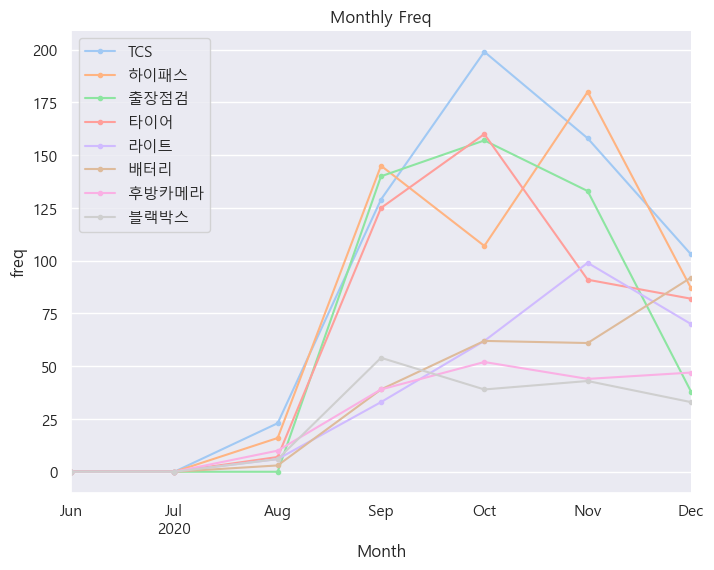

In [29]:
temp = pd.DataFrame()
for word, count in recategory_top20[2:10]:
    temp[word] = normal.groupby(pd.Grouper(key='dates', freq='M'))['recategory'].apply(lambda x: x[x == word].count())

temp.plot(marker='.')
plt.title('Monthly Freq')
plt.xlabel('Month')
plt.ylabel('freq')
plt.show()

In [27]:
model.wv.most_similar('배터리', topn=10)

[('배터리교환', 0.48826560378074646),
 ('후패드', 0.48685628175735474),
 ('전패드', 0.4711616039276123),
 ('배터리방전', 0.4409596621990204),
 ('점화플러그', 0.43691307306289673),
 ('미션오일', 0.42477086186408997),
 ('브레이크액', 0.42336487770080566),
 ('시동', 0.41628286242485046),
 ('배터리방전으로', 0.40926387906074524),
 ('시동유지', 0.3977958559989929)]